# Промежуточный проект

<pre>
ФИО: Никифоров Владимир
</pre>

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


from math import sqrt
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectFromModel


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
RANDOM_STATE = 7
N_FOLDS = 3
models = []

In [5]:
raw_df = pd.read_csv('../data/data.csv')
print(f'Shape of dataset: {raw_df.shape}')
raw_df.head()

Shape of dataset: (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 1. EDA

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [7]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


We have missing values, zero visibility and different ranges of values wich need to be scaled.

In [8]:
feat_ignore = ['Item_Identifier','Outlet_Identifier']
feat_y = ['Item_Outlet_Sales']
feat_num = [c for c,t in zip(raw_df.columns, raw_df.dtypes) if t != "object" and c not in (feat_ignore + feat_y)]
feat_cat = [c for c,t in zip(raw_df.columns, raw_df.dtypes) if t == "object" and c not in (feat_ignore + feat_y)]
print(feat_num, feat_cat)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'] ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


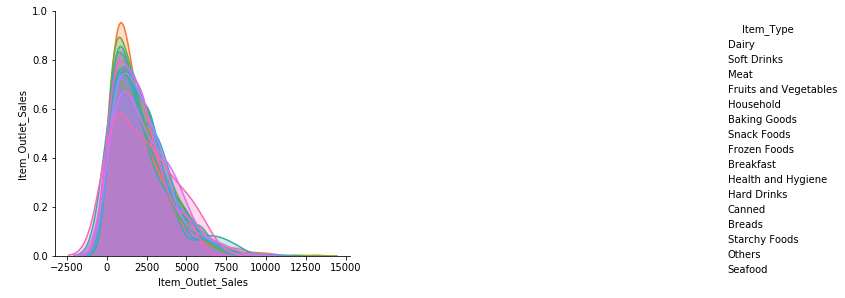

In [9]:
# Sales in store have exponential distribution
g=sns.pairplot(data=raw_df[['Item_Outlet_Sales','Item_Type']], hue='Item_Type',plot_kws={'alpha':0.2});
g.fig.set_size_inches(15,5)

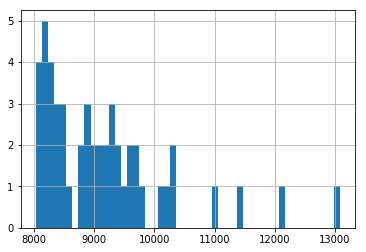

In [10]:
raw_df[raw_df['Item_Outlet_Sales']>8000]['Item_Outlet_Sales'].hist(bins=50);

We have some outliers in Item_Outlet_Sales

In [11]:
raw_df[raw_df['Item_Outlet_Sales']>10000]['Item_Outlet_Sales'].value_counts()

13086.9648    1
11445.1020    1
10236.6750    1
10306.5840    1
10993.6896    1
10256.6490    1
12117.5600    1
10072.8882    1
Name: Item_Outlet_Sales, dtype: int64

### 1.1. Eliminate missing values

There are missing values in attributes. Let's fill missing categorical attributes values with "Undefined" and try to fill numeric attributes values with not-NaN values from other rows.

In [12]:
raw_df['Outlet_Size'] = raw_df['Outlet_Size'].fillna('Undefined')

In [13]:
raw_df[raw_df['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Undefined,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
33,FDO23,17.850,Low Fat,0.0,Breads,93.1436,OUT045,2002,Undefined,Tier 2,Supermarket Type1,2174.5028
46,NCP05,19.600,Low Fat,0.0,Health and Hygiene,153.3024,OUT045,2002,Undefined,Tier 2,Supermarket Type1,2428.8384
60,FDM20,10.000,Low Fat,0.0,Fruits and Vegetables,246.9144,OUT018,2009,Medium,Tier 3,Supermarket Type2,3185.1872
72,FDH35,18.250,Low Fat,0.0,Starchy Foods,164.7526,OUT045,2002,Undefined,Tier 2,Supermarket Type1,4604.6728
79,FDV25,5.905,Low Fat,0.0,Canned,222.5456,OUT045,2002,Undefined,Tier 2,Supermarket Type1,5305.0944


There are 526 rows with sales without visibility. We might filter them to clear the data.

In [14]:
print(len(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique()))
raw_df[np.isnan(raw_df['Item_Weight'])].head()

1142


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


We have missing values for Item_Weight for 1142 unique Item_Identifier. We can try to fill it from other non-missing rows for each Item_Identifier

In [15]:
raw_df[raw_df['Item_Identifier']=='DRI11']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,Undefined,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,Undefined,Tier 2,Supermarket Type1,1612.5676


In [16]:
max(raw_df[(raw_df['Item_Identifier']=='DRI11') & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight'].values)

8.26

In [17]:
# We will create additional dataframe with not-NaN weights
raw_df_weights = pd.DataFrame(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique(),columns=['Item_Identifier'])

In [18]:
raw_df_weights.head()

,Item_Identifier
0,FDP10
1,DRI11
2,FDW12
3,FDC37
4,FDC14


In [19]:
raw_df_weights['weight'] = raw_df_weights.apply(lambda x: max(raw_df[(raw_df['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight'].values) if len(raw_df[(raw_df['Item_Identifier']==x['Item_Identifier']) & (~np.isnan(raw_df['Item_Weight']))]['Item_Weight']) > 0 else np.nan, axis=1)

In [20]:
raw_df_weights.head()

,Item_Identifier,weight
0,FDP10,19.000
1,DRI11,8.260
2,FDW12,8.315
3,FDC37,15.500
4,FDC14,14.500


In [21]:
print(len(raw_df_weights[raw_df_weights['Item_Identifier']=='FDP10']))
raw_df_weights[raw_df_weights['Item_Identifier']=='FDP10']['weight'].values[0]

1


19.0

In [22]:
# Let's fill original dataframe with not-NaN values
raw_df['Item_Weight'] = raw_df.apply(lambda x: (raw_df_weights[raw_df_weights['Item_Identifier']==x['Item_Identifier']]['weight'].values[0]) if np.isnan(x['Item_Weight']) else x['Item_Weight'], axis=1)

In [23]:
raw_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Undefined,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [24]:
print(len(raw_df[np.isnan(raw_df['Item_Weight'])]['Item_Identifier'].unique()))
raw_df[np.isnan(raw_df['Item_Weight'])]

4


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


There are only 4 distinct Item_Identifier left in 4 rows with NaN-values in Item_Weight. Let's drop them.

In [25]:
raw_df.dropna(inplace=True)

In [26]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8519 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8519 non-null object
Item_Visibility              8519 non-null float64
Item_Type                    8519 non-null object
Item_MRP                     8519 non-null float64
Outlet_Identifier            8519 non-null object
Outlet_Establishment_Year    8519 non-null int64
Outlet_Size                  8519 non-null object
Outlet_Location_Type         8519 non-null object
Outlet_Type                  8519 non-null object
Item_Outlet_Sales            8519 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


In [27]:
raw_df['Outlet_Establishment_Year'].value_counts()

1985    1459
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

### 1.2. Work with categorical features

In [28]:
# Let's take a look on unique feature's values count
_ = [print(c, len(raw_df[c].unique())) for c in feat_cat]

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


We can use one-hot encoding as soon as number of unique values of categorical features is not high.

In [29]:
# Combine dataframe with dummies from categorical features
df = pd.concat([raw_df[feat_num + feat_y],pd.get_dummies(raw_df[feat_cat])],axis=1)
print(df.shape)

(8519, 37)


### 1.3. Correlation with Item_Outlet_Sales

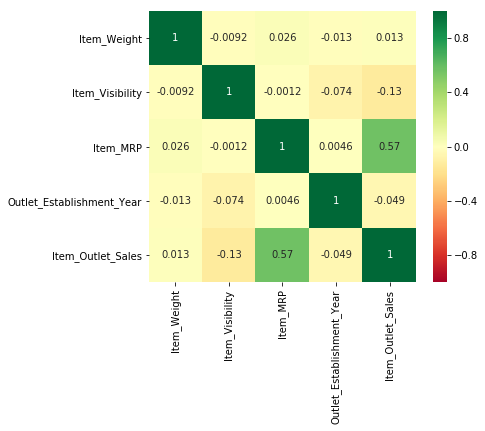

In [30]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(raw_df.corr(),annot=True,cmap="RdYlGn",vmin=-1,vmax=1);

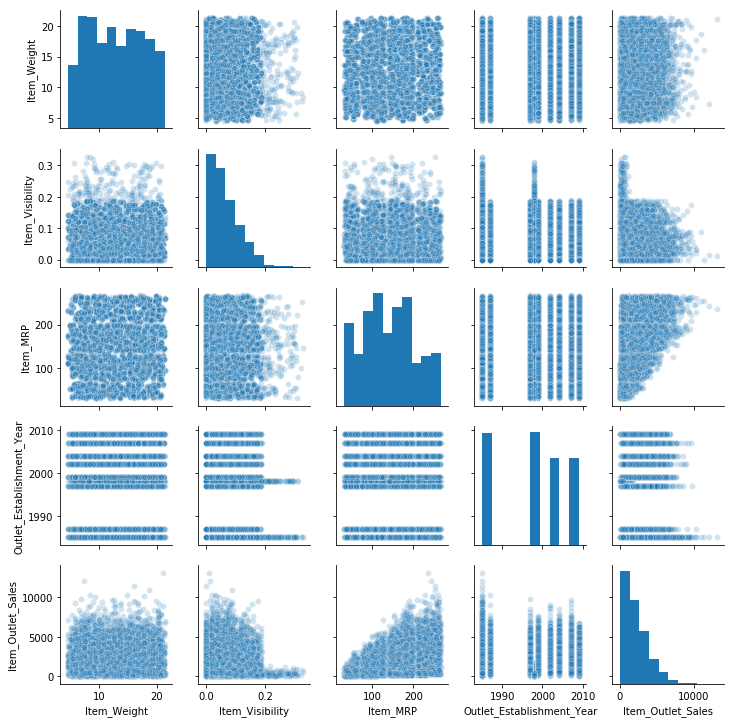

In [31]:
g=sns.pairplot(data=raw_df,plot_kws={'alpha':0.2});
g.fig.set_size_inches(10,10)

There is one strong correlation with Item_Outlet_Sales - Item_MRP.

/home/truename/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


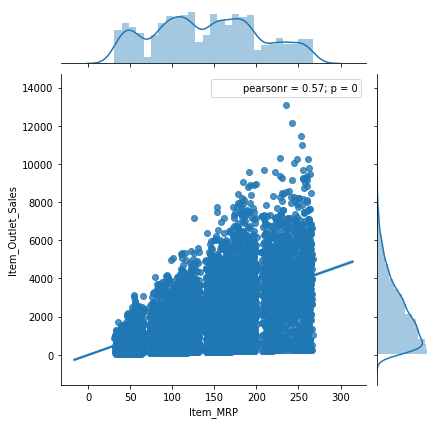

In [32]:
# There is correlation between Item_MRP and Item_Outlet_Sales
sns.jointplot(data=raw_df,y='Item_Outlet_Sales',x='Item_MRP',kind='reg',stat_func=pearsonr);

/home/truename/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


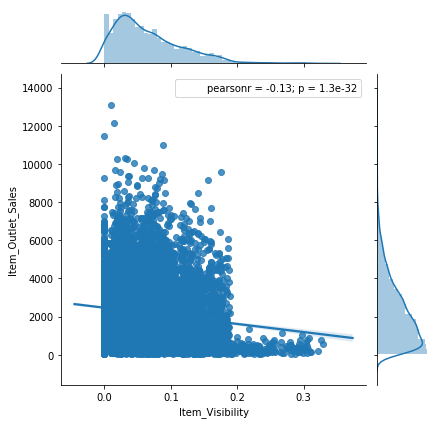

In [33]:
# There is no strong correlation between Item_Visibility and Item_Outlet_Sales
sns.jointplot(data=raw_df,y='Item_Outlet_Sales',x='Item_Visibility',kind='reg',stat_func=pearsonr);

## 2. Choose the metric

*  There are to many metrics for regression: R2, MSE, MAE, MAPE, MAE%, RMSE. 
*  The commonly used metric for regression in store-product sales are MAE% (if there are outliers, good because of median calculation) and RMSE (if there are zeros in sales, good because of average calculation of error between two trends).
*  Let's look at MAE% and RMSE metrics:

MAE% is the mean of the absolute error divided by the average values observed to get a %.

$${\displaystyle MAE\%={\frac {\frac{1}{N}\sum_{i=1}^{N}|y_i - h_\theta(x_i)|}{\frac{1}{N}\sum_{i=1}^{N}y_i}}}$$

The root-mean-square error (RMSE) is a frequently used measure of the differences between values predicted by a model or an estimator and the values observed. The RMSE represents the square root of the differences between predicted values and observed values. The RMSE serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSE is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent. @wiki

$${\displaystyle RMSE={\sqrt {\frac{1}{N}\sum_{i=1}^{N}(y_i - h_\theta(x_i))^2}}}$$

In [34]:
def get_mae_percent(y_actual, y_predicted):
    '''
    Function return MAE_percent
    Input:  y_actual - true Y
            y_predicted - predicted Y
    Output: MAE%
    '''
    assert y_actual.values.mean()!=0
    return mean_absolute_error(y_true=y_actual.values, y_pred=y_predicted)/y_actual.values.mean()

def get_rmse(y_actual, y_predicted):
    '''
    Function return RMSE
    Input:  y_actual - true Y
            y_predicted - predicted Y
    Output: RMSE
    '''
    return sqrt(mean_squared_error(y_actual.values, y_predicted))

def get_metrics(y_actual, y_predicted):
    '''
    Function return metrics of accuracy in regression
    Input:  y_actual - true Y
            y_predicted - predicted Y
    Output: MAE%, RMSE    
    '''
    return get_mae_percent(y_actual, y_predicted), get_rmse(y_actual, y_predicted)

In [35]:
def fit_model(model, X_train, y_train):
    '''
    Function to fit the model
    Output: Fitted model
    '''
    model.fit(X_train, y_train)
    return model

def predict_and_test(model, X_test, y_test):
    '''
    Function to predict on fitted model and test the accuracy of prediction
    Output: model and metrics
    '''
    y_pred = model.predict(X_test)
    mtrx = get_metrics(y_test, y_pred)
    print(f'MAE% = {mtrx[0]}, RMSE = {mtrx[1]}')
    return model, mtrx[0], mtrx[1]

def fit_and_test(model, X_train, y_train, X_test, y_test):
    '''
    Function to fit, predict and test the model
    Output: model and metrics
    '''
    model = fit_model(model, X_train, y_train)
    return predict_and_test(model, X_test, y_test)

## 3. Linear model

In [36]:
models = []

In [37]:
# Split dataframe to train/test/validation dataframes
# Split to train_and_valid and test (OOB)
df_train_and_valid, df_test = train_test_split(df, random_state=RANDOM_STATE, test_size=0.3)
df_train, df_valid = train_test_split(df_train_and_valid, random_state=RANDOM_STATE, test_size=0.15)

Because of linear model we need to scale our dataset

In [38]:
sc = preprocessing.StandardScaler()
# Fit and transform scaler to the train dataset
df_train[feat_num] = sc.fit_transform(df_train[feat_num])
# Apply fitted scaler to the validation and test datasets
df_valid[feat_num], df_test[feat_num] = sc.transform(df_valid[feat_num]), sc.transform(df_test[feat_num])

In [39]:
# Split df to X and y
X_train, X_valid, X_test, y_train, y_valid, y_test = df_train.drop(feat_y, axis=1), df_valid.drop(feat_y, axis=1), df_test.drop(feat_y, axis=1), df_train[feat_y].squeeze(), df_valid[feat_y].squeeze(), df_test[feat_y].squeeze()
assert df.shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
assert df.shape[0] == len(y_train) + len(y_valid) + len(y_test)
print(X_train.shape, X_valid.shape, X_test.shape, len(y_train), len(y_valid), len(y_test))

(5068, 36) (895, 36) (2556, 36) 5068 895 2556


Check our scaled dataset

In [40]:
# Look at the final X_train-dataset after scaling to assure that mean is equal to zero and std is equal to 1
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,5068.0,2.505669e-16,1.000099,-1.793197,-0.866735,-0.063369,0.854454,1.826268
Item_Visibility,5068.0,1.566536e-16,1.000099,-1.289703,-0.765809,-0.235403,0.573502,4.928020
Item_MRP,5068.0,-1.049542e-16,1.000099,-1.778660,-0.760639,0.027024,0.728097,2.025632
Outlet_Establishment_Year,5068.0,-1.135282e-14,1.000099,-1.517691,-1.280151,0.145088,0.738937,1.332787
Item_Fat_Content_LF,5068.0,3.808208e-02,0.191413,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_Low Fat,5068.0,5.972770e-01,0.490494,0.000000,0.000000,1.000000,1.000000,1.000000
Item_Fat_Content_Regular,5068.0,3.358327e-01,0.472327,0.000000,0.000000,0.000000,1.000000,1.000000
Item_Fat_Content_low fat,5068.0,1.460142e-02,0.119963,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Fat_Content_reg,5068.0,1.420679e-02,0.118354,0.000000,0.000000,0.000000,0.000000,1.000000
Item_Type_Baking Goods,5068.0,7.280979e-02,0.259850,0.000000,0.000000,0.000000,0.000000,1.000000


In [41]:
# Let's train simple linear model
model_linear = LinearRegression(n_jobs=-1)
models.append(fit_and_test(model_linear, X_train, y_train, X_valid, y_valid))

MAE% = 0.3698001925579582, RMSE = 1052.883635042408


In [42]:
print('Coefficients: \n', model_linear.coef_, "\n")
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_linear.coef_.T):
    print(feature, coeff)

Coefficients: 
 [-4.65311695e+00 -7.22157523e+00  9.58742220e+02  3.17130446e+02
 -1.05443293e+02 -3.54127873e+01  1.60122930e+01  1.42168680e+02
 -1.73248923e+01 -2.20261750e+01  2.08096974e+01  7.88751347e+00
  4.24655870e+01 -9.17028121e+01 -5.69957205e+01  2.26739667e+01
 -2.08513215e+01  3.47989430e+01  2.29324412e+01  4.85006078e+00
 -7.21083341e-01  1.11722613e+02 -1.06621738e+01 -7.09197258e+01
  5.73818914e+00  6.17240435e+02 -1.62207546e+02 -1.63968476e+02
 -2.91064413e+02  1.93854174e+02  2.14685375e+01 -2.15322712e+02
 -1.59759370e+03 -1.03473063e+02 -4.98759028e+02  2.19982579e+03] 

Feature:  Weight:
Item_Weight -4.653116952183545
Item_Visibility -7.221575227025872
Item_MRP 958.7422204569348
Outlet_Establishment_Year 317.1304461190708
Item_Fat_Content_LF -105.44329349678456
Item_Fat_Content_Low Fat -35.41278731348576
Item_Fat_Content_Regular 16.012292976519284
Item_Fat_Content_low fat 142.16868012105255
Item_Fat_Content_reg -17.32489228728781
Item_Type_Baking Goods -22.02

#### Let's try to use regularization in linear models:

In [43]:
# Use L1-regularization
model_L1 = Lasso(random_state=RANDOM_STATE)
models.append(fit_and_test(model_L1, X_train, y_train, X_valid, y_valid))

# The coefficients
print('Coefficients: \n', model_L1.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L1.coef_.T):
    print(feature, coeff)

MAE% = 0.3705021877084306, RMSE = 1054.8447538674561
Coefficients: 
 [   -2.60313656    -7.18130427   957.74021312    57.45825724
   -63.09823272   -15.72319039    29.11731136    93.19657494
    -0.            -9.00421129     0.             0.
    27.83048252   -83.50375072   -45.68874396    14.39338658
    -0.            12.85562639     8.24169331     0.
    -0.             0.            -6.50247944   -55.73704187
     0.            36.42013373    36.91581591    -0.
  -105.66909897    -0.            20.61093052    -0.
 -1888.27116623     0.          -478.02908533  1464.30332932]
Feature:  Weight:
Item_Weight -2.603136558978287
Item_Visibility -7.181304265171462
Item_MRP 957.7402131214258
Outlet_Establishment_Year 57.45825724345437
Item_Fat_Content_LF -63.09823271545747
Item_Fat_Content_Low Fat -15.723190386582194
Item_Fat_Content_Regular 29.117311363276784
Item_Fat_Content_low fat 93.19657494226058
Item_Fat_Content_reg -0.0
Item_Type_Baking Goods -9.004211294592892
Item_Type_Breads 0.

In [44]:
# Train linear model with L2-regularization
model_L2 = Ridge()
models.append(fit_and_test(model_L2, X_train, y_train, X_valid, y_valid))

# The coefficients
print('Coefficients: \n', model_L2.coef_)
print('Feature:  Weight:')
      
for feature, coeff in zip(X_train.columns,model_L2.coef_.T):
    print(feature, coeff)

MAE% = 0.3698371989232889, RMSE = 1053.0645378382742
Coefficients: 
 [-4.45823138e+00 -7.54234244e+00  9.58586185e+02  2.54969962e+02
 -1.05484935e+02 -3.53065974e+01  1.61720551e+01  1.41107393e+02
 -1.64879159e+01 -2.14932968e+01  1.96858027e+01  9.50385052e+00
  4.24945462e+01 -9.15704758e+01 -5.61314612e+01  2.29862076e+01
 -2.05534521e+01  3.45937561e+01  2.28321952e+01  4.72513831e+00
  1.14449052e-01  1.08074850e+02 -1.07840220e+01 -7.02829089e+01
  5.80482148e+00  4.78637008e+02 -1.02262865e+02 -1.24075312e+02
 -2.52298831e+02  1.39370360e+02  2.44989066e+01 -1.63869267e+02
 -1.60115359e+03 -1.88634239e+01 -4.48526397e+02  2.06854341e+03]
Feature:  Weight:
Item_Weight -4.458231375121089
Item_Visibility -7.542342441113776
Item_MRP 958.5861850970498
Outlet_Establishment_Year 254.96996229399386
Item_Fat_Content_LF -105.4849349253109
Item_Fat_Content_Low Fat -35.30659735943578
Item_Fat_Content_Regular 16.172055138186877
Item_Fat_Content_low fat 141.10739303280235
Item_Fat_Content_r

In [45]:
models

[(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
  0.3698001925579582,
  1052.883635042408),
 (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=7,
        selection='cyclic', tol=0.0001, warm_start=False),
  0.3705021877084306,
  1054.8447538674561),
 (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
        normalize=False, random_state=None, solver='auto', tol=0.001),
  0.3698371989232889,
  1053.0645378382742)]

In [46]:
print(f'And the winner in linear models is: \
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]}\n MAE%=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][1]}\n RMSE=\
      {sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][2]}')

And the winner in linear models is:       LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
 MAE%=      0.3698001925579582
 RMSE=      1052.883635042408


In [47]:
# Store the best linear model to the model_lr for stacking
model_lr = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0]

## 4. Non-Linear model

In [48]:
# Let's train RandomForest with LUCKY-parameters (most usefull in retail-regression tasks)
model_rf_def = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, random_state=RANDOM_STATE)
models.append(fit_and_test(model_rf_def, X_train, y_train, X_valid, y_valid))

MAE% = 0.3423489960002473, RMSE = 1032.4825672245402


Looks like RandomForest is better than linear models. Let's find the best params for RandomForest.

In [49]:
# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = {'n_estimators': list(range(50,250,50)),
              'max_depth': list(range(5,25,5)),
              'min_samples_leaf': list(range(1,31,10)),
              'max_features': list(np.linspace(0.6,1,5)),
             }
print(param_grid)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 11, 21], 'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [50]:
# Now we want to score only by MAE%
model_rf_grd = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
grid = GridSearchCV(model_rf_grd, param_grid, cv=N_FOLDS, n_jobs=-1)

In [51]:
# fit the grid with data
grid.fit(X_train, y_train)
print(grid.best_params_)
# Get the model with the best params
model_rf = grid.best_estimator_
models.append(fit_and_test(model_rf, X_train, y_train, X_valid, y_valid))
#default RF: MAE% = 0.3423489960002473, RMSE = 1032.4825672245402

{'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 21, 'n_estimators': 100}
MAE% = 0.3393287826963435, RMSE = 1022.7178185383154


Grid gave us the best model with more improvements!

## 5. Stack models

Let's stack linear and non-linear models!

In [52]:
def get_meta_features(clf, X_train, y_train, X_valid, y_valid, stack_cv):
    '''
    Function to prepare meta-features to train new model based on stacked-models prediction and y_actual
    Output: X of predictions of sub-models on TRAIN, and X of prediction of sub-models on VALID/TEST datasets
    '''
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_valid = np.zeros_like(y_valid, dtype=float)
    
    for i, (train_ind, valid_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[valid_ind] = clf.predict(X_train.iloc[valid_ind])
        meta_valid += clf.predict(X_valid)
    
    return meta_train, meta_valid / stack_cv.n_splits

In [53]:
# Define KFold with N_FOLDS splits
stack_cv = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
# Get predictions of train/valid datasets as new meta-features for the best linear model
meta_tr, meta_te = get_meta_features(model_lr, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
# Get predictions of train/valid datasets as new meta-features for the best RandomForest model
meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_valid, y_valid, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...
RF features...


In [54]:
# Transform it to the pandas-DataFrame
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Now stack the models with LinearRegression!

In [55]:
# Train new LinearRegression model on predictions of the best linear-model and randomforest-model
model_lr_meta = LinearRegression(n_jobs=-1)
_ = fit_and_test(model_lr_meta, X_meta_train, y_train, X_meta_test, y_valid)

MAE% = 0.33976248347962673, RMSE = 1018.3890886444206


We've got even better accuracy!

#### Now take a look at our union model and it coefficients!

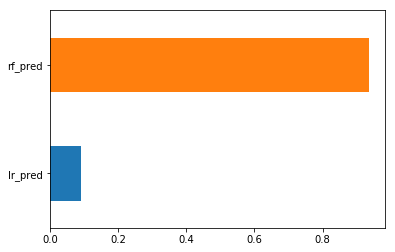

In [56]:
# Look at histogram of coefficients of models's predictions in our ensemble-model
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh');

RandomForest is the most important in this ensemble!

## 6. Score on TEST dataset

Let's check accuracy of this ensemble on TEST dataset

In [57]:
meta_test = []

# Adding linear regression
_, meta_te = get_meta_features(model_lr, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)

# Adding RandomForest
_, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, y_test, stack_cv)
meta_test.append(meta_te)
# Result X-dataset
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)
# Test the accuracy of our ensemble on TEST-dataset
_ = predict_and_test(model_lr_meta, X_meta_test, y_test)

MAE% = 0.3536150627831636, RMSE = 1107.8076655670627


Test accuracy on all non-ensemble models for compare with ensemble:

In [58]:
# List of all trained models with their predictions
for m in models:
    print(m[0], predict_and_test(m[0], X_test, y_test))

MAE% = 0.39104043427498114, RMSE = 1159.8343854187444
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False) (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), 0.39104043427498114, 1159.8343854187444)
MAE% = 0.3900773273394243, RMSE = 1157.9996848743642
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False) (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=7,
      selection='cyclic', tol=0.0001, warm_start=False), 0.3900773273394243, 1157.9996848743642)
MAE% = 0.3903668579304941, RMSE = 1159.0218586926387
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) (Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normal

We can see that ensemble errors are not the smallest, but smaller than most part of the simple models on TEST-dataset.

## 7. Variable importance and TOP-3

We will use the best model for feature importance extraction:

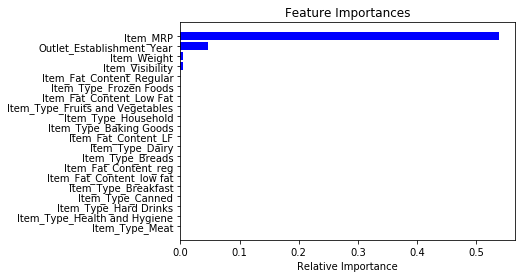

In [59]:
features = X_train.columns
# Take a look on the TOP-20 variables in variable importance
importances = sorted(models, key=lambda x: (x[1],x[2]), reverse=False)[0][0].feature_importances_[0:20]
# Sort features by their importances
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

__We can see that Item_MRP, Outlet_Establishment_Year and Item_Weight are in the TOP-3 variable by importance in prediction of Item_Outlet_Sales.__

__And while we can't always change Item_Weight - we can change Items_Visibility, which is as important variable as Item_Weight, based on the importance of variables from the best model.__